# About this assignment
#### Technical Requirements
*  Just a browser to use the binder version!
+ Students are expected to know how to:
 + call variables from dataframes
 + format basic equations in R (e.g. adding, multiplying, subtracting variables) for calculations
 + use ggplot to create basic plots
    
#### Conceptual Prerequisites
+ Students should have a working knowledge of least squares fitting/linear regression of two variables. 
+ Students should have a working knowledge of methods for evaluating statistical models and quantifying error. 
+ Students should have a general understanding of paleo-ocean temperature proxies. 
  
#### Learning Goals
+ Students will learn computational tools that make calculating, plotting, and evaluating linear regressions fast and efficient. 
+ Students will learn to compare many linear regressions of a multivariate data set to select an optimal model. 
+ Students will learn to make predictions from a linear regression model and quantify the error associated with the predictions. 
+ Students will compare several GDGT paleo temperature proxy calibrations and their associated errors. 

#### How to use this assignment

<div style="background: #efffed;
            border: 1px solid grey;
            margin: 8px 0 8px 0;
            text-align: center;
            padding: 8px; ">
    <i class="fa-play fa" 
       style="font-size: 40px;
              line-height: 40px;
              margin: 8px;
              color: #444;">
    </i>
    <center>
    Click into a code cell (the gray blocks below) to select or edit it.<br/>
    To run a selected code cell, hit <pre style="background: #efffed">Shift + Enter</pre>
    Make sure that each code cell runs successfully before you move on to the next one.
    </center>
</div>


# Introduction to linear regression in R
You should be familiar with the mathematics and important statistics involved with linear regression. In this assignment you will use R to calculate and evaluate many linear regressions quickly. R was specifically designed for statistical computing, and it offers many helpful tools and functions for regression. This section will introduce some of the tools that will be helpful later in this assignment. 

#### Linear regression in R: lm()
Linear regressions in R can be quickly calculated using the function `lm()`, which stands for "linear model". You should view the documentation for `lm()` now by entering `?lm` at the command line or searching lm in the RStudio help pane (and note that you can find documentation for any R function this way).

`lm()` requires a *formula*, which defines the variables, and these can be data values themselves (i.e. a numeric vector) or variable names which appear the second argument, *data*. In general it is more effective to use variable names in the *formula* and provide the data in *data* because this makes it easier to use the model to make predictions on new data later. 

Let's load a dataset of water chemistry measurements from a hot spring in Yellowstone National Park [USGS 2009-2013](https://www.usgs.gov/media/files/yellowstone-water-chemistry-final-data-2009-2013)) and plot pH vs. Temperature. 

In [27]:
# Load all the libraries that are used in this assignment. 
# If you get an error from this code block, something is missing and you should talk to your instructor.
library(tidyverse, quietly = TRUE) # for working with data and plotting
library(broom) # for linear regressions
library(latex2exp) # for math symbols in plots
library(readxl) # for reading data from Excel
source(file.path("scripts", "functions.R")) # custom functions
message("libraries loaded")

libraries loaded


In [28]:
# Read in Ojo Caliente dataset (USGS 2009-2013)
# https://www.usgs.gov/media/files/yellowstone-water-chemistry-final-data-2009-2013)

ojo <- 
    suppressWarnings(
    read_excel(
        file.path("data", "ojo_caliente_data.xlsx"), 
        na = "---", 
        col_types = c(rep(c("text", "date", "text"), each = 2), rep("numeric", 88))
    )) %>% 
    select_if(function(x) any(!is.na(x))) # Remove empty columns

ojo

Name and Description,Sample Code Number,Collection Date,Collection Time,Latitude,Longitude,Map (figure),Photograph (appendix),pH (best),pH (field),⋯,Yb (µg/L),Zn (µg/L),Zr (µg/L),DOC (mg/L),δD (‰),δ18O (‰),Charge Imbalance (%),Specific Conductance Imbalance (%),Sum Cations (meq/L),Sum Anions (meq/L)
Ojo Caliente - source (30 m depth),09WA139,2009-09-15,1899-12-31 14:10:00,"44° 33' 46.1""","110° 50' 17.2""",11,NA,7.55,7.55,⋯,0.006,2.6,0.405,6.7,-141.34,-16.450,-3.15,-5.67,14.28,14.74
Ojo Caliente - source (15 m depth),09WA140,2009-09-15,1899-12-31 15:00:00,"44° 33' 46.1""","110° 50' 17.2""",11,NA,7.41,7.41,⋯,NA,1.9,0.375,3.3,-141.39,-16.540,-2.73,-4.04,14.56,14.97
Ojo Caliente - source (1 m depth),09WA138,2009-09-15,1899-12-31 11:00:00,"44° 33' 46.1""","110° 50' 17.2""",11,NA,7.52,7.52,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Ojo Caliente - pool exit (pool exit),09WA141,2009-09-15,1899-12-31 15:30:00,"44° 33' 46.1""","110° 50' 17.2""",11,NA,7.45,7.45,⋯,NA,2.2,0.732,0.8,-141.59,-16.450,-7.52,-2.01,14.53,15.67
Ojo Caliente - overflow (3.6 m from pool exit),09WA142,2009-09-15,1899-12-31 16:00:00,NA,NA,11,89,7.52,7.52,⋯,NA,2.3,0.891,0.7,-142.01,-16.290,-4.84,-2.30,14.79,15.53
Ojo Caliente - overflow (8.1 m from pool exit),09WA143,2009-09-15,1899-12-31 16:20:00,NA,NA,11,NA,7.64,7.64,⋯,NA,1.3,0.509,0.7,-141.12,-16.330,-2.92,-0.62,15.27,15.73
Ojo Caliente - overflow (11.7 m from pool exit),09WA144,2009-09-15,1899-12-31 16:40:00,NA,NA,11,NA,7.71,7.71,⋯,NA,1.4,0.670,0.7,-140.64,-16.360,-5.38,-0.20,15.12,15.95
Ojo Caliente - overflow (15 m from pool exit),09WA145,2009-09-15,1899-12-31 17:00:00,NA,NA,11,NA,7.79,7.79,⋯,NA,1.5,1.110,0.7,-141.19,-16.290,-8.18,-1.00,14.80,16.06
Ojo Caliente - overflow (20 m from pool exit),09WA146,2009-09-15,1899-12-31 17:20:00,NA,NA,11,NA,7.90,7.90,⋯,NA,2.3,1.820,0.8,-140.57,-16.210,1.14,-6.23,15.10,14.93
Ojo Caliente - overflow (26 m from pool exit),09WA147,2009-09-15,1899-12-31 17:40:00,NA,NA,11,90,8.19,8.19,⋯,NA,1.3,0.969,0.7,-139.74,-15.980,-5.71,-6.72,14.62,15.48


Now plot temperature versus pH.

Warning message:
“Removed 21 rows containing missing values (geom_point).”

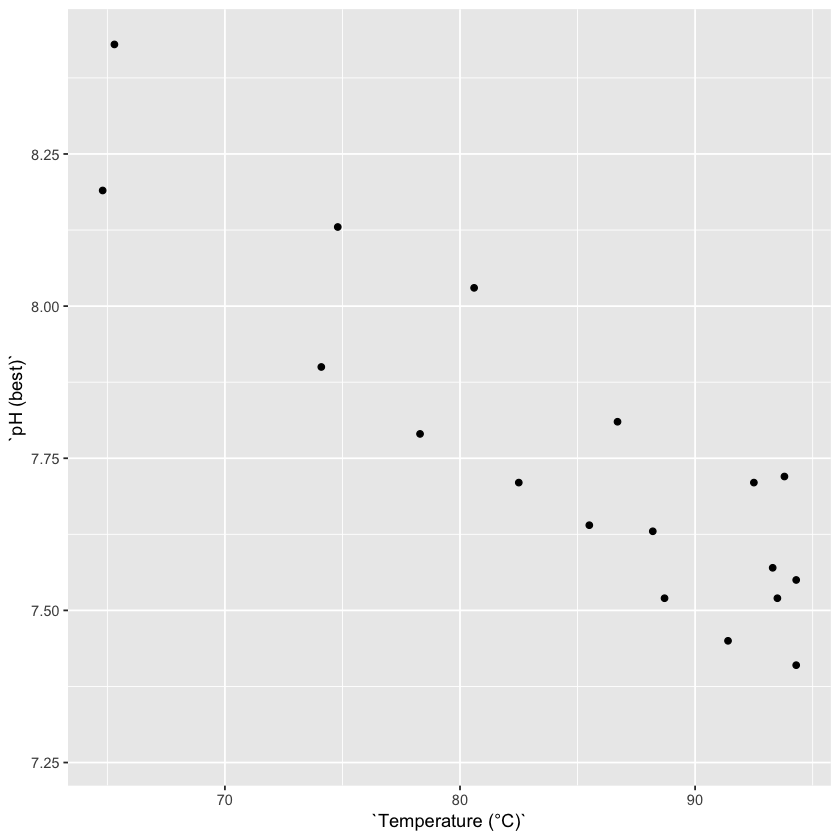

In [29]:
ojo %>% 
    ggplot(aes(x = `Temperature (°C)`, y = `pH (best)`)) + 
    geom_point() 

Plot some more combinations of variables from the Ojo Caliente data set and choose a correlation to fit with a linear regression. 

Warning message:
“Removed 21 rows containing missing values (geom_point).”

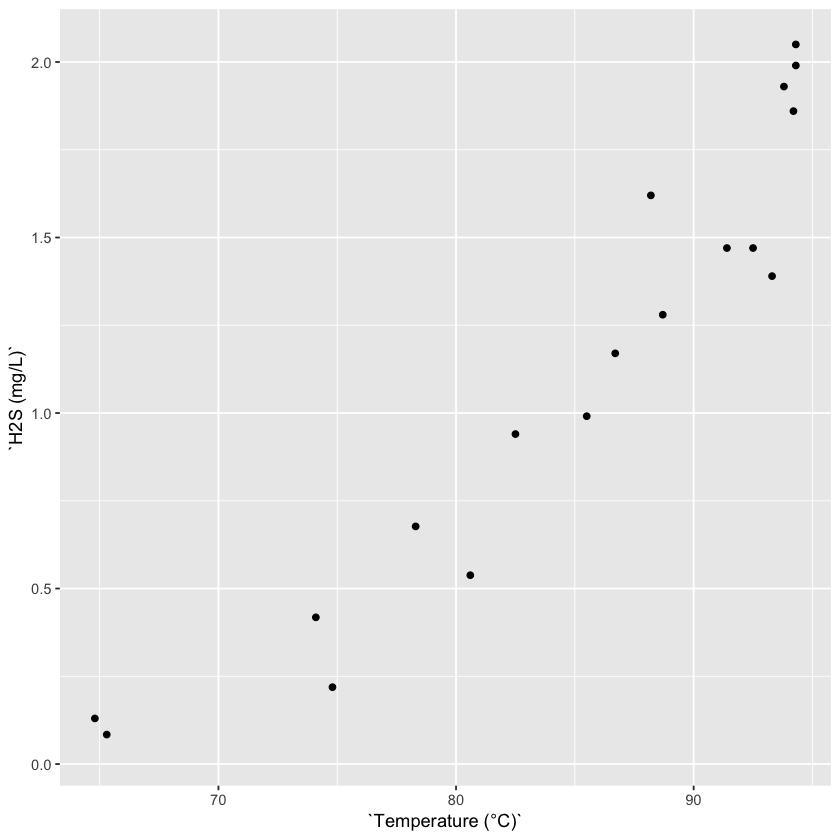

In [30]:
ojo %>% # Hint: explore ojo by running `ojo` on its own.
    ggplot(aes(x = `Temperature (°C)`, y = `H2S (mg/L)`)) + # Hint: Use backticks (``) around variable names.
    geom_point() 

Once you've chosen the variables you would like to regress, use `lm()` to calculate a linear regression. `glance()` is a useful function for printing an overview of the model. 

In [31]:
# Simple linear models have the form y ~ x
ojo_lm <- lm(`H2S (mg/L)` ~ `Temperature (°C)`, data = ojo) 

glance(ojo_lm)

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
0.8963101,0.8898295,0.2184456,138.3063,2.754273e-09,2,2.901079,0.1978413,2.868957,0.7634959,16


Now let's plot your linear regression with the data. We've provided a function `geom_lm()` that adds a fit, as well as confidence intervals ($1\sigma$, blue) and prediction intervals ($1\sigma$, red), for convenience. 

Warning message:
“Removed 21 rows containing missing values (geom_point).”

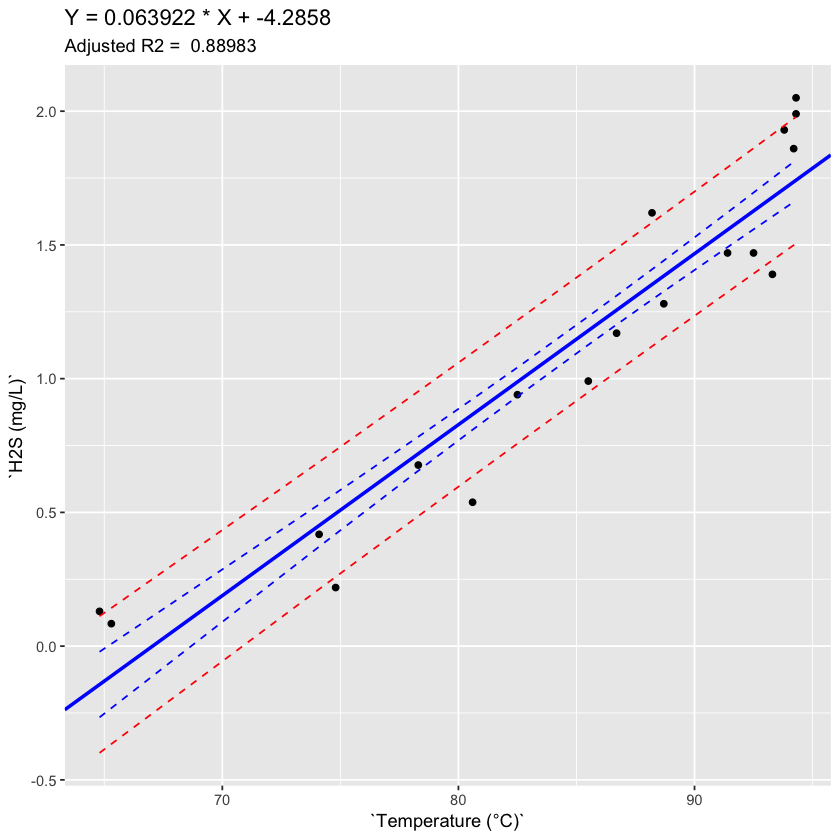

In [32]:
ojo %>% 
    ggplot(aes(x = `Temperature (°C)`, y = `H2S (mg/L)`)) +
    geom_point() +
    geom_lm(ojo_lm) # Hint: geom_lm() needs your linear model. 

# Applying linear regression to a paleotemperature proxy calibration ($TEX_{86}^L$)

Biomarker-based paleothermometry is based upon the biochemical principle that microorganisms adjust the rigidity of their cell membrane structures in response to temperature. A popular biomarker paleothermometer is based on the relative abundances of archaeal glycerol dialkyl glycerol tetraethers (GDGTs). These molecules consist of two 40-carbon isoprenoidal chains (made up of isoprene units) that have a varying number of cyclopentane rings. These chains are connected by ether bonds to terminal glycerol groups (see diagram below). With increasing temperature, source archaea (namely *Thaumarcheota*), produce GDGTs with more rings because these structures have higher melting points (e.g. are more stable at warm temperatures). 

![diagram modified from Tierney (2012)](data/gdgt_structures.png){width=70%}

The $TEX_{86}$ ratio is a mathematical representation of the degree of cyclization of GDGTs. This ratio can be empirically calibrated to temperature, typically with a linear relationship for use as a paleotemperature proxy. An alternate form of the $TEX_{86}$ ratio, $TEX_{86}^L$, was proposed by Kim et al. 2010 for better prediction at low temperatures. 

$$
TEX_{86}^L = log(\frac{[GDGT-2]}{[GDGT-1] + [GDGT-2] + [GDGT-3]})
$$

In this exercise, you will find the best empirical $TEX_{86}^L$ local temperature calibration for surface sediment in Iceland. You will then apply this calibration to a core and compare your local calibration to existing regional calibrations previously published in the literature. 

## Import and manipulate data

Run this block of code to import $TEX_{86}^L$ data from surface sediment in Iceland.

If you open the dataframe Iceland_TEX86_data, you can see $TEX_{86}^L$ ratios of surface sediment from various sites in Iceland are recorded. Samples with a "Surface sed ID" of 313-347 are from Harning et al. (2018); samples with a "Surface sed ID" of 1-13 are from Rodrigo-Gámiz et al.(2015). Also included are the climatological mean temperatures for these sites from Locarnini et al. (2010).

In [33]:
#load file containing Iceland surface sediment TEX86 ratios and sea surface temperatures

Iceland_TEX86_data <- read_csv(file.path("data", "TEX86_Iceland_calibration_2.csv"), col_names = TRUE)

Iceland_TEX86_data

ERROR: Error: 'data/TEX86_Iceland_calibration_2.csv' does not exist in current working directory ('/Users/sk/GDrive/classes/2018_comp_tools/ps-epi-binder').


*Thaumarcheota*, the major producers of GDGTs, are ubiquitious in the world's oceans. These organisms are nitrifiers, oxidizing ammonium with oxygen, and thus can be found anywhere in the water column where these compounds are present. While *Thaumarcheota* can be found in soils, the concentrations of GDGTs produced in soil environments are typically much lower compared to marine environments. Most $TEX_{86}$ calibrations use annual sea surface temperature, assuming that the source of GDGTs is planktonic *Thaumarcheota* and that these microorganisms are responding to surface temperatures. 

#### 1. Do you think it is valid to assume that the *Thaumarcheota*'s lipids will respond to the average annual sea surface temperature? Why or why not?

> Answer: No, the *Thaumarcheota* are more likely to respond to the temperature at the depth where they grow, and the temperature at the time of year when they grow. 

In the dataframe you loaded above, you have been provided seasonal and annual temperature depth integrations. Run the following code block to generate linear regressions for each temperature profile.

In [ ]:
#filter dataframe to include just response and predictor variables to use downstream
T_profiles <- Iceland_TEX86_data[,5:80]

#create dataframe with response and predictor columns for regression
df <- T_profiles
response_var <- "TEX86L"

vars <- tibble(response=response_var,
               predictor= paste0("`", setdiff(names(df), response_var), "`")) # Make the col names behave

#create string of formulas to feed to lm() function
formulas <- paste0(response_var, "~", vars$predictor) # Just the variables, not the lm() part

models <- data_frame(formulas) %>% # pass formulas to lm()function
    mutate(model = map(formulas, ~  lm(as.formula(.), data = df))) %>%
  unnest(map(model, glance), .drop=T)

#pull out seasons from formula column
models <- models %>% 
  mutate(
  season = case_when(
  grepl("Ann", .$formulas) ~ "Annual",
  grepl("Wint", .$formulas, ignore.case = TRUE) ~ "Winter",
  grepl("Spring", .$formulas) ~ "Spring",
  grepl("Fall", .$formulas) ~ "Fall",
  grepl("Summer", .$formulas) ~ "Summer"
  )) %>% #pull out depths from temperature profiles
  mutate(depthint = ifelse(grepl("SST", formulas), 
                           "SST", 
                           str_extract(formulas, "0.*m"))) %>% 
  mutate(depth = ifelse(grepl("SST", depthint), 
                           0, 
                           as.numeric(substring(depthint, 3, nchar(depthint) - 1))))

models

Take a look at the `models` data frame this has generated to explore the statistics that have been calculated for all of the models. 

## Plotting $r^2$ versus integrated depth for each seasonal temperature profile

To compare the regressions for each temperature profile, plot the **adjusted** $r^2$ value of each regression vs depth, using color to denote season. 

In [ ]:
models %>% 
  arrange(depth) %>% 
  ggplot(aes(y = adj.r.squared, x = depth, color = season)) +
  geom_line() + 
  geom_point() + 
  coord_flip() + 
  xlim(200,0) +
  xlab('Depth (m)') +
  ylab(TeX('adjusted $r^2$'))

#### 2. Which season(s) and integrated depth(s) of temperature has the most robust relationship with GDGT cyclization?

> Answer: The highest adjusted $r^2$ value is found for winter temperatures with a depth integration of ~150-200 m. (Incidentally, evaluating the model on the basis of any of the other regression statistic yields a similar result).

#### 3. What can you infer about GDGT production and preservation at these sites based on how the correlation depends on season and depth integration?

> Answer: Since the strongest correlation is observed between $TEX_{86}^L$ and the Winter temperature integrated over large depth, it appears that *Thaumarchareota* growth and GDGT production occurs throughout the water column, perhaps with preferential preservation in winter.

## Calculate the most robust regression for modern Iceland surface sediment

#### 4. Using your plot from the previous problem, choose one integrated depth and season for your local calibration. Justify your choice.

> Answer: Any of the models of $TEX_{86}^L$ for winter, and with depth integration > ~50 m would be appropriate. 

Use the function lm() to run a linear regression for your chosen temperature profile and save this regression as "best_model." Then plot your regression model using geom_lm().

In [ ]:
# Reminder: lm format is lm(y ~ x)
best_model <- lm(`Wint. 0-200m` ~ TEX86L, data = df)

df %>% 
  ggplot(aes(x = TEX86L, y = `Wint. 0-200m`)) + 
  geom_lm(best_model) +
  geom_point(color = "blue") + 
  xlab(TeX('$TEX^L_{86}$')) +
  ylab('Temperature in C, Winter 0-200m')
  

## Comparing models

![Kim et al, 2010 regression](data/kim_reg_2010.PNG){width=70%}

![Kim et al, 2012 regression](data/kim_reg_2012.PNG){width=70%}

Above are two temperature calibrations for $TEX_{86}^L$. The first is from Kim et al. 2010, which uses global SST. The second is an updated calibration from Kim et al. 2012 which uses an annual 200 m depth integration.

#### 5. How do these calibrations compare with your local calibration (e.g. temperature range, $r^2$)? How can you explain these differences?

> Answer: The local calibration is confined to a much smaller temperature interval, since the ocean temperarature in Iceland is relatively cool. The slope of the local calibration is also lower, suggesting variation in the $TEX_{86}^L$-T relationship between localities. The degree of fit is better than the global calibrations for the temperature range, supporting the conclusions that the relationship varies with locality. 

#### 6. From examining the plots above, what would you estimate the overall error associated with a temperature estimate from $TEX_{86}^L$ to be? How does this compare to your local model?

> Answer: The error in temperature inferred from the global calibrations is perhaps +/- 5 °C, especially at the lower temperatures that the local calibration covers. The error on the local calibration is +/- <2 °C.

#### 7. Would the uncertainty estimate vary depending on the measured $TEX_{86}^L$ value?

> Answer: Certainly for the global calibrations, where the error/uncertainty is elevated at low temperatures (< 20 °C).

## Application of models to an Iceland core

Let's apply each of these calibrations to a sediment core from Iceland.

Import the sediment core data from Harning et al. (2018). If you open the dataframe, you can see that each core sample has an associated depth, age, and $TEX_{86}^L$ ratio. Ages were extrapolated from radiocarbon dating of mollusks in the core. 

In [ ]:
data <- read_excel(file.path("data", "TEX86_record_NIS.xlsx"), col_names = TRUE)

data

First, use the $TEX_{86}^L$ ratio, your linear regression, and the regressions from Kim et al. (2010) and (2012) to calculate a GDGT-derived temperature. Then, input the standard residual error associated with your model into the dataframe. Finally, plot the derived temperature and associated error vs. age.

In [ ]:
data <- data %>% mutate(
  kim2010 = (67.5 * TEX86L + 46.9), 
  kim2012 = (50.8 * TEX86L + 36.1), 
  best_model = (27.947 * TEX86L + 22.742)
) %>% 
  gather(model, estimate, kim2010:best_model) %>% 
  mutate(error = case_when(
    model == "kim2010" ~ 2,
    model == "kim2012" ~ 2.8,
    model == "best_model" ~ sd(best_model$residuals)
  ))

data %>% 
  ggplot(aes(x = `CLAM age CE`, 
             y = estimate, 
             color = model, 
             ymin = estimate - error, 
             ymax = estimate + error)) + 
  geom_line() +
  geom_point() +
  geom_errorbar() +
  labs(
    x = "Year",
    y = "Estimated Temperature (°C)"
  )


#### 8. What effect does applying a local calibration have on the relative and absolute GDGT-derived temperatures?

> Answer: The temperature estimate is systematically higher with the local calibration. The variation in the record is also dampened, but the overall pattern of increases and decreases in temperature is consistent between models.

#### 9. What might be a more appropriate estimate of error for GDGT-derived temperature in the core?

> Answer: Using the predictive interval would be more appropriate because we are applying a model to predict the response of membrane GDGTs to temperature in the core using a calibration calculated from surface sediments in a trap. 

# References
Harning, D.J., Sepúlveda, J., Cabedo-Sanz, P., Andrews, J.T., Belt, S.T., Dildar, N., Geirsdóttir, Á., Miller, G.H.(2018). Sea ice control on winter subsurface temperatures of the North Iceland Shelf over the last millennium. Paleoceanography and Paleoclimatology, submitted. 

Kim, J. H., Crosta, X., Willmott, V., Renssen, H., Bonnin, J., Helmke, P., . Sinninghe Damst?, J. S. (2012). Holocene subsurface temperature variability in the eastern Antarctic continental margin. Geophysical Research Letters, 39(6), 3-8. https://doi.org/10.1029/2012GL051157

Kim, J. H., van der Meer, J., Schouten, S., Helmke, P., Willmott, V., Sangiorgi, F., . Damst?, J. S. S. (2010). New indices and calibrations derived from the distribution of crenarchaeal isoprenoid tetraether lipids: Implications for past sea surface temperature reconstructions. Geochimica et Cosmochimica Acta, 74(16), 4639-4654. https://doi.org/10.1016/j.gca.2010.05.027

Locarnini, R.A., Mishonov, A.V., Antonov, J.I., Boyer, T.P., Garcia, H.E., Baranova, O.K., Zweng, M.M., Johnson, D.R. (2010). World Ocean Atlas 2009, Volume 1: Temperature. S. Levitus, Ed. NOAA Atlas NESDIS 68, U.S. Government Printing Office, Washington, D.C., 184 pp

Rodrigo-Gámiz, M., Rampen, S.W., de Haas, H., Baas, M., Schouten, S., Sinninghe-Damsté, J.S. (2015). Constraints on the applicability of the organic temperature proxies Uk37´, TEX86 and LDI in the subpolar region around Iceland. Biogeosciences 12, 6573-6590.

Tierney. J. (2012). Reconstructing Earth’s Deep-Time Climate—The State of the Art, The Paleontological Society Papers, Volume 18, Linda C. Ivany and Brian T. Huber (eds.),
pp. 115–131.